# Fingerprint distances between structures for the same kinase

In this notebook, we investigate the ranges of fingerprint distances for each kinase pair.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from kissim.comparison import FingerprintDistanceGenerator
from kissim.encoding import FingerprintGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.75

## Load fingerprints

In [7]:
fingerprints = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")

In [8]:
fingerprint_bits = [
    fingerprint.values_array(True, True, True) for _, fingerprint in fingerprints.data.items()
]
fingerprint_bits = pd.DataFrame(fingerprint_bits)

In [9]:
fingerprint_bits.shape

(4916, 1032)

### Fingerprint bit coverage

In [10]:
fingerprint_coverage = 100 - fingerprint_bits.isna().sum(axis=1) / fingerprint_bits.shape[0] * 100
fingerprint_coverage = fingerprint_coverage.sort_values(ascending=False)
fingerprint_coverage.name = "Fingerprint coverage"

<AxesSubplot:>

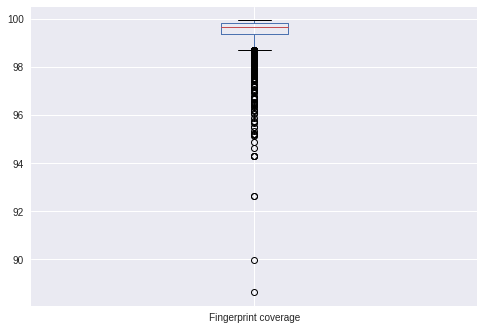

In [11]:
fingerprint_coverage.plot(kind="box")

In [12]:
fingerprint_coverage.describe()

count    4916.000000
mean       99.504838
std         0.631407
min        88.628967
25%        99.389748
50%        99.674532
75%        99.837266
max        99.938975
Name: Fingerprint coverage, dtype: float64

## Load fingerprint distances

In [13]:
fingerprint_distance_file = RESULTS / "fingerprint_distances.csv"

In [14]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)

In [15]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 292
bla
Number of structures: 4916


In [16]:
structure_distances = fingerprint_distance_generator.data

### Sort fingerprint/kinase pairs (alphabetically)

In [17]:
%%time

structure_distances["structure_pair"] = (
    structure_distances[["structure.1", "structure.2"]].apply(list, axis=1).apply(sorted)
)
structure_distances["kinase_pair"] = (
    structure_distances[["kinase.1", "kinase.2"]].apply(list, axis=1).apply(sorted)
)

structure_distances["structure.1"] = [i[0] for i in structure_distances["structure_pair"]]
structure_distances["structure.2"] = [i[1] for i in structure_distances["structure_pair"]]
structure_distances["kinase.1"] = [i[0] for i in structure_distances["kinase_pair"]]
structure_distances["kinase.2"] = [i[1] for i in structure_distances["kinase_pair"]]
structure_distances = structure_distances.drop(["structure_pair", "kinase_pair"], axis=1)
structure_distances.head()

CPU times: user 2min 24s, sys: 2.64 s, total: 2min 27s
Wall time: 2min 27s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,3835,6679,AAK1,AAK1,0.051608,0.992667
1,3835,7156,AAK1,AAK1,0.059276,0.991333
2,1104,3835,AAK1,ABL1,0.275259,0.990667
3,1065,3835,AAK1,ABL1,0.284854,0.990667
4,1090,3835,AAK1,ABL1,0.262851,0.990667


## Fingerprint pair coverage

### Coverage between fingerprint pairs

In [18]:
COVERAGE_CUTOFF = 0.8

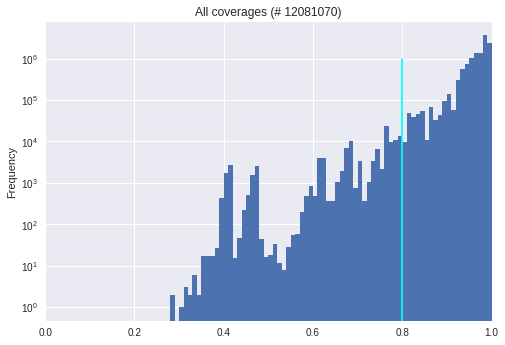

In [19]:
fig, ax = plt.subplots(1, 1)
structure_distances["bit_coverage"].plot(
    kind="hist",
    title=f"All coverages (# {structure_distances.shape[0]})",
    bins=np.arange(0, 1.05, 0.01),
    xlim=(0, 1),
    logy=True,
)
ax.plot([COVERAGE_CUTOFF, COVERAGE_CUTOFF], [0, 1000000], color="cyan")

We might want to filter out some fingerprint pairs because the coverage is super low.

In [20]:
structure_distances["bit_coverage"].describe()

count    1.208107e+07
mean     9.654150e-01
std      4.037688e-02
min      2.893333e-01
25%      9.553333e-01
50%      9.793333e-01
75%      9.873333e-01
max      9.973333e-01
Name: bit_coverage, dtype: float64

### Filter distances by coverage cutoff

In [21]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,distance_filtered
0,3835,6679,AAK1,AAK1,0.051608,0.992667,0.051608
1,3835,7156,AAK1,AAK1,0.059276,0.991333,0.059276
2,1104,3835,AAK1,ABL1,0.275259,0.990667,0.275259
3,1065,3835,AAK1,ABL1,0.284854,0.990667,0.284854
4,1090,3835,AAK1,ABL1,0.262851,0.990667,0.262851


In [22]:
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]

In [23]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 12081070
Structure pairs not-NaN: 11964546


### Number of kinases/structures (pairs)

In [24]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [25]:
n_structures = (
    pd.concat([structure_distances["structure.1"], structure_distances["structure.2"]])
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat([structure_distances["kinase.1"], structure_distances["kinase.2"]]).unique().shape[0]
)
n_structures_filtered = (
    pd.concat(
        [structure_distances_filtered["structure.1"], structure_distances_filtered["structure.2"]]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat([structure_distances_filtered["kinase.1"], structure_distances_filtered["kinase.2"]])
    .unique()
    .shape[0]
)


table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        structure_distances.groupby(["kinase.1", "kinase.2"]).size().shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        structure_distances_filtered.groupby(["kinase.1", "kinase.2"]).size().shape[0],
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

,All distances,Only distances matching cutoff
Number of structures,4916,4897
Number of structure pairs (theory),12085986,11992753
Number of structure pairs (experimental),12081070,11964546
Number of kinases,292,288
Number of kinase pairs (theory),42778,41616
Number of kinase pairs (experimental),42717,41507
